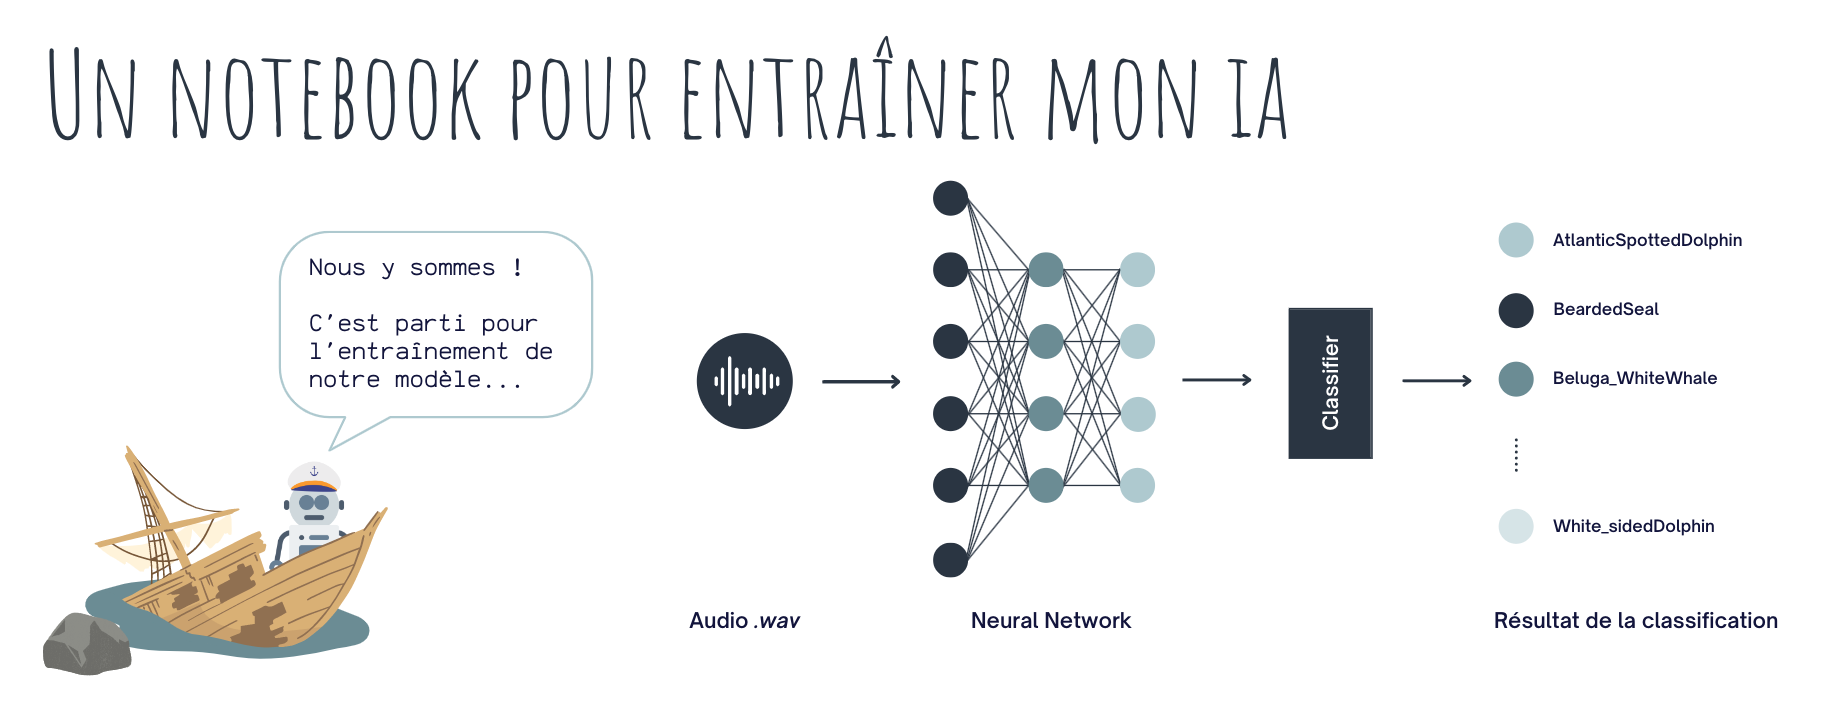

## 1. Importation des bibliothèques Python

In [1]:
# audio signal analysis
import librosa
import librosa.display

# command shell for interactive computing
import IPython

# display graphs
import matplotlib.pyplot as plt

# matrices or multidimensional arrays handling 
import numpy as np

# data handling and analysis
import pandas as pd

# data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# define and train an AI model
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential

## 2. Test sur un son 

In [2]:
test_sound = "/workspace/data/marine-mammal-sound-test1.wav"

- Chargement et décodage du son :

In [3]:
data, sr = librosa.load(test_sound)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [4]:
librosa.load(test_sound ,sr = sr)

(array([-0.04325062, -0.04760704, -0.04125222, ...,  0.01476261,
         0.01511474,  0.        ], dtype=float32),
 22050)

- Jouer un son avec `IPython.display.Audio` :

In [5]:
IPython.display.Audio(data, rate = sr)

- Waveforms :

Représentations visuelles du son sous forme de temps sur l'axe des x et d'amplitude sur l'axe des y. 

Elles permettent une analyse rapide des données audio.

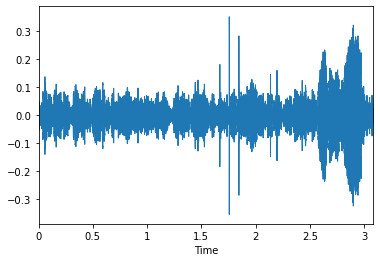

In [6]:
plt.show(librosa.display.waveplot(data))

## 3. Prétraitement des données

Lien vers le dataset : [Watkins marine mammal sound database](https://cis.whoi.edu/science/B/whalesounds/index.cfm)

### a. Fichier `data.csv`

Pour entraîner le modèle, les données doivent être pré-traitées. Tout d'abord, il faut convertir les fichiers `.wav` en fichier `.csv`.

- Définition des colonnes :

In [ ]:
header = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean \
        perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var mfcc4_m

- Création du fichier `data.csv` :

In [ ]:
file = open("data.csv", "w", newline = "")
with file:
    writer = csv.writer(file)
    writer.writerow(header)

- Définir la chaîne de caractère des nom de mammifères marins (45):

> 45 mammifères marins différents <=> 45 classes

In [ ]:
marine_mammals = "AtlanticSpottedDolphin BeardedSeal Beluga_WhiteWhale BlueWhale BottlenoseDolphin Boutu_AmazonRiverDolphin BowheadWhale ClymeneDolphin \
        Commerson'sDolphin CommonDolphin Dall'sPorpoise DuskyDolphin FalseKillerWhale Fin_FinbackWhale FinlessPorpoise Fraser'sDolphin Grampus_Risso'sDolphin \
        GraySeal GrayWhale HarborPorpoise HarbourSeal HarpSeal Heaviside'sDolphin HoodedSeal HumpbackWhale IrawaddyDolphin JuanFernandezFurSeal KillerWhale \
        LeopardSeal Long_FinnedPilotWhale LongBeaked(Pacific)CommonDolphin MelonHeadedWhale MinkeWhale Narwhal NewZealandFurSeal NorthernRightWhale \
        PantropicalSpottedDolphin RibbonSeal RingedSeal RossSeal Rough_ToothedDolphin SeaOtt

- Transformer chaque son `.wav` en une ligne du fichier `.csv` :

In [ ]:
for animal in marine_mammals:

    for filename in os.listdir(f"/workspace/data/{animal}/"):

        sound_name = f"/workspace/data/{animal}/{filename}"
        y, sr = librosa.load(sound_name, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
        rmse = librosa.feature.rms(y = y)
        spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
        spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y = y, sr = sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

        for e in mfcc:
            to_append += f' {np.mean(e)}'

        to_append += f' {animal}'
        file = open('data.csv', 'a', newline = '')

        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

- Afficher le fichier `data.csv` :

In [7]:
df = pd.read_csv('/workspace/data/data.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,label
0,6102603E.wav,0.426664,0.042434,5157.104325,3101.100191,8617.587891,0.356964,-241.481033,24.920166,48.238968,...,13.670743,-0.705876,12.712521,1.321301,10.524447,0.343317,6.712308,0.371731,1.841404,AtlanticSpottedDolphin
1,61026030.wav,0.434773,0.053204,5594.399169,2860.406861,8655.933556,0.434289,-228.107635,-4.825935,60.204544,...,11.302414,2.397469,13.868607,-2.265396,11.323673,0.582180,6.923624,-2.080763,1.947379,AtlanticSpottedDolphin
2,61026048.wav,0.432415,0.042047,5135.238139,2982.555668,8378.181032,0.365667,-244.113342,12.709079,48.617630,...,15.568404,-2.544822,10.559988,-0.473371,8.464706,0.382612,6.677320,2.163096,3.520124,AtlanticSpottedDolphin
3,6102603I.wav,0.438314,0.076127,5803.472083,3099.706089,9038.656456,0.414833,-198.311844,0.518129,47.096676,...,15.731695,0.987929,16.382414,-0.967779,8.810925,1.867840,9.033828,2.434472,3.793100,AtlanticSpottedDolphin
4,61026047.wav,0.416906,0.081022,5043.428899,2982.812198,8271.866648,0.322625,-234.926605,12.705063,54.443558,...,15.146926,1.311773,13.756646,-0.811321,8.872554,3.451088,6.508763,-0.489402,4.719871,AtlanticSpottedDolphin


In [8]:
# dataframe types
df.dtypes

filename                    object
length                     float64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
label                       object
dtype: object

### b. Extraction des caractéristiques

- Extraction de caractéristiques (nécessaire avant de lancer l'entraînement)
- Objectif : définir les **entrées** et **sorties** du réseau neuronal

- **SORTIE** (y) : dernière colonne qui est le `label`.

Nous ne pouvons pas utiliser directement du texte pour l'entraînement => nous allons encoder ces labels avec la fonction **LabelEncoder()** de **sklearn.preprocessing**.

Avant de pouvoir exécuter un modèle, nous devons convertir ce type de données textuelles catégorielles en données numériques que le modèle peut comprendre.

In [9]:
class_list = df.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(class_list)
print("y: ", y)

y:  [ 0  0  0 ... 44 44 44]


- **INPUTS** (X) : toutes les autres colonnes sont des paramètres d'entrée du réseau neuronal, sauf le nom de fichier.

Nous supprimons la première colonne qui ne fournit aucune information pour l'apprentissage (le nom de fichier) et la dernière qui correspond à la sortie.

In [10]:
input_parameters = df.iloc[:, 1:27]
scaler = StandardScaler()
X = scaler.fit_transform(np.array(input_parameters))
print("X:", X)

X: [[-0.71758759  0.20419758  1.17840861 ...  0.59678504  0.59680033
  -0.43635211]
 [-0.66140594  0.48716815  1.44344394 ...  0.6360472   0.11020783
  -0.41656124]
 [-0.67774188  0.19402336  1.16515597 ...  0.59028425  0.95222009
  -0.12285259]
 ...
 [-1.00584499  1.27000953  0.84831611 ...  0.55786759 -0.3320992
   0.63891663]
 [-0.26724693  0.69987104 -0.84229563 ...  0.42982227  0.82545802
   0.16668007]
 [ 1.77048234 -0.63530507  0.03279294 ...  0.70826513  0.53040824
   0.66172722]]


## 4. Séparation des données pour l'entraînement

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Construction du modèle

La première étape consiste à construire le modèle et à afficher le résumé.

Pour le modèle **ANN**...
- toutes les couches cachées utilisent une fonction d'activation **ReLU**.
*Cette fonction permet d’effectuer un filtre sur nos données. Elle laisse passer les valeurs positives (x > 0) dans les couches suivantes du réseau de neurones. Elle est utilisée presque partout mais surtout pas dans la couche final, elle est utilisée dans les couches intermédiaires.*

- la couche de sortie utilise une fonction **Softmax**.
*La fonction Softmax permet elle de transformer un vecteur réel en vecteur de probabilité. On l’utilise souvent dans la couche finale d’un modèle de classification, notamment pour les problèmes multiclasse.*

- un **Dropout** est utilisé pour éviter l'overfitting.
*Le terme  » Dropout  » fait référence à la suppression de neurones dans les couches d’un modèle de Deep Learning. On désactive temporairement certains neurones dans le réseau, ainsi que toutes ses connexions entrantes et sortantes*

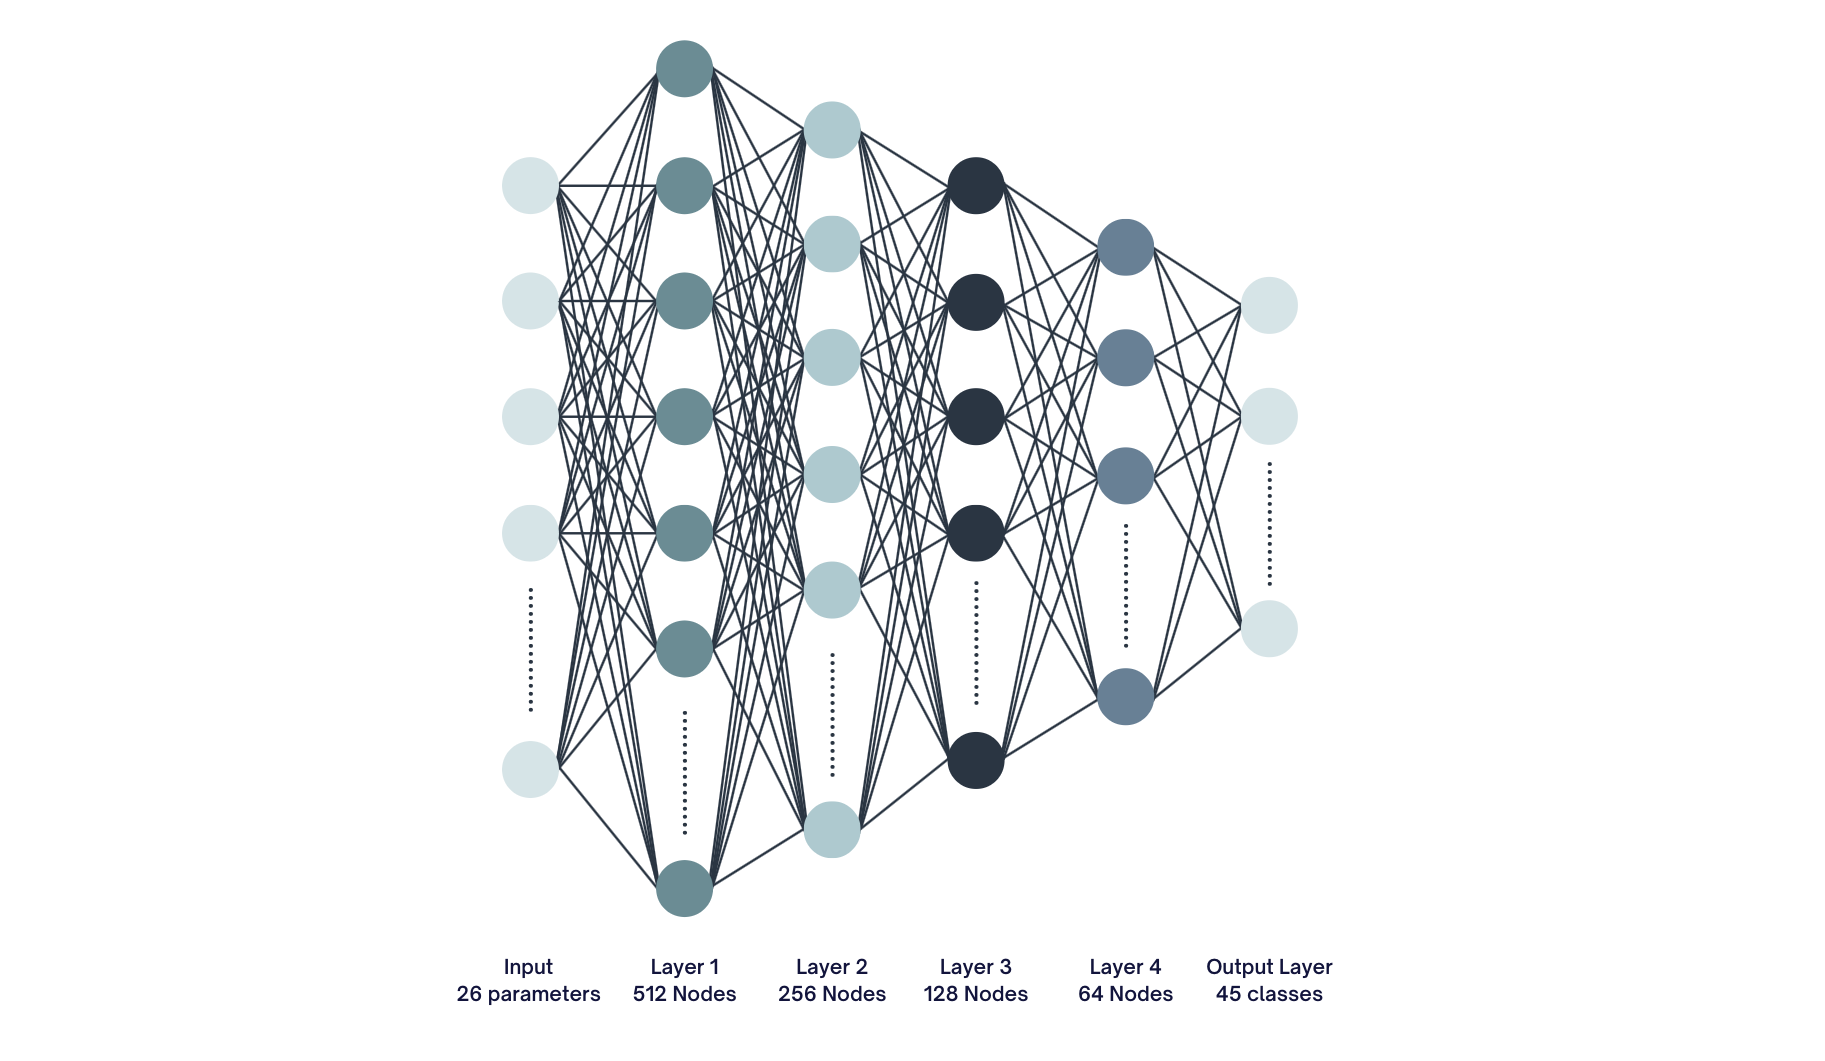

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(45, activation = 'softmax'),
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

## 5. Entraînement et évaluation du modèle

L'optimiseur **Adam** est utilisé pour entraîner le modèle sur 100 époques. Ce choix a été fait car il nous permet d'obtenir de meilleurs résultats.

- Calcul de la perte avec la fonction **sparse_categorical_crossentropy**

In [13]:
def trainModel(model,epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epochs, batch_size = batch_size)

- Lancement de l'entraînement :

In [14]:
model_history = trainModel(model = model, epochs = 100, optimizer = 'adam')

Epoch 1/100
79/79 [==============================] - 2s 11ms/step - loss: 2.8459 - accuracy: 0.3231 - val_loss: 1.1758 - val_accuracy: 0.6908
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 1.3004 - accuracy: 0.6422 - val_loss: 0.8282 - val_accuracy: 0.7680
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.9950 - accuracy: 0.7142 - val_loss: 0.6687 - val_accuracy: 0.8189
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.8130 - accuracy: 0.7634 - val_loss: 0.5528 - val_accuracy: 0.8460
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.7987 - val_loss: 0.5029 - val_accuracy: 0.8587
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.6105 - accuracy: 0.8243 - val_loss: 0.4315 - val_accuracy: 0.8810
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.5541 - accuracy: 0.8353 - val_loss: 0.3861 - val_accuracy: 0.8910
Epoch 8/100


- Affichage de la courbe de perte - **loss** :

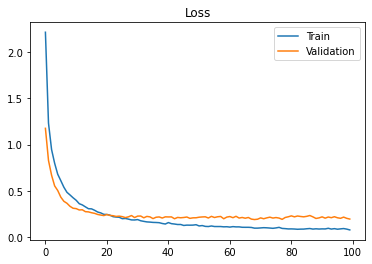

In [15]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

- Affichage des courbes de précision - **accuracy** :

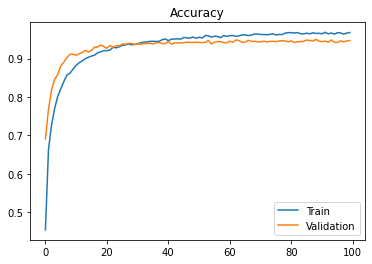

In [16]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(X_val, y_val, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

20/20 [==============================] - 0s 1ms/step - loss: 0.1938 - accuracy: 0.9471
The test loss is:  0.19383981823921204
The best accuracy is:  94.70751881599426


## 7. Exporter le modèle pour une future inférence

In [18]:
model.save('/workspace/data/ai-model/model-marine-mammal-sounds-classification')

INFO:tensorflow:Assets written to: /workspace/ai-model/model-marine-mammal-sounds-classification/assets


In [19]:
# my_model directory
%ls /workspace/data/ai-model/model-marine-mammal-sounds-classification

assets/  saved_model.pb  variables/


In [20]:
model = tf.keras.models.load_model('/workspace/data/ai-model/model-marine-mammal-sounds-classification')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13824     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8